<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/catagotical%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [19]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
import tracemalloc
from scipy.stats import norm
from statistics import NormalDist

import tensorflow_probability as tfp

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Concatenate, GaussianNoise
from tensorflow.keras.regularizers import l2


### <font color='purple'><center>**-------------------Create Data-------------------**</font>

In [4]:
end_date = datetime.now() - timedelta(days=1)
start_date = end_date - timedelta(days=728)

tickers = [
    'EURUSD=X', 'USDEUR=X',  # Euro/US Dollar
    'USDJPY=X', 'JPYUSD=X',  # US Dollar/Japanese Yen
    'GBPUSD=X', 'USDGBP=X',  # British Pound/US Dollar
    'USDCHF=X', 'CHFUSD=X',  # US Dollar/Swiss Franc
    'AUDUSD=X', 'USDAUD=X',  # Australian Dollar/US Dollar
    'USDCAD=X', 'CADUSD=X',  # US Dollar/Canadian Dollar
    'NZDUSD=X', 'USDNZD=X',  # New Zealand Dollar/US Dollar
]

data_list = []
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date, interval='1h')
    data_list.append(data)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
def create_data(raw_data, window_size):
    High = raw_data['High'].to_numpy()
    Close = raw_data['Close'].to_numpy()
    Low = raw_data['Low'].to_numpy()
    Std = np.std(np.diff(Close))
    Close_Diff = np.diff(Close)/Std
    High_Adj = (High[1:]-Close[1:])/Std
    Low_Adj = (Close[1:]-Low[1:])/Std

    stack = np.stack((Close_Diff, High_Adj, Low_Adj), axis=1)

    window_view = np.lib.stride_tricks.sliding_window_view(stack, (window_size,),axis=0)

    Forex_Data = window_view[:-1]
    Forex_Data = Forex_Data.astype('float32')
    target = Close_Diff[window_size:]

    return Forex_Data, target


In [6]:
window_list = []
target_list = []
for data in data_list:
    window, target =  create_data(data, 50)
    window_list.append(window)
    target_list.append(target)


In [84]:
# Assume data is your numpy array and bins is a numpy array defining your bins
data = target_list[0]
input_data = window_list[0]
for i in range(len(target_list)-1):

  data = np.append(data,target_list[i+1])
  input_data = np.append(input_data, window_list[i+1],axis=0)


In [176]:
espi = .000001
min = np.min(data)-espi
max = np.max(data)+espi

large = np.max((np.abs(min),np.abs(max)))

data2 = data/large*.5
data2 = data2+.5

stdddd = np.std(data2)
meanie = np.mean(data2)

inverse_transformed_array = norm.cdf(data2, loc=.5, scale=stdddd*1.5)

inverse_transformed_array = (inverse_transformed_array-.5)#*(large/.5)



True


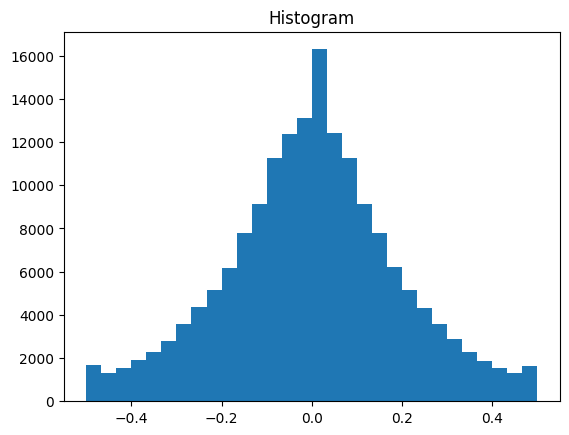

In [178]:
def check_signs(arr1, arr2):
  return np.all(np.sign(arr1) == np.sign(arr2))

print(check_signs(inverse_transformed_array,data))
plt.hist(inverse_transformed_array, bins=30)
plt.title("Histogram")
plt.show()

In [179]:

bin_num = 51
space = .5
bins = np.linspace(-space, space, bin_num-1)
digitized = np.digitize(inverse_transformed_array, bins, right=False)
digitized = tf.keras.utils.to_categorical(digitized)
shape = digitized.shape[1]

In [ ]:
from keras.optimizers import Adam

Drop_val=.5
# Initialize the model
model = Sequential()

# Add the LSTM layer
model.add(LSTM(128,dropout=Drop_val,recurrent_dropout=Drop_val))

model.add(BatchNormalization())

model.add(Dense(100,activation='gelu'))

model.add(BatchNormalization())

model.add(Dropout(Drop_val))

model.add(Dense(50,activation='gelu'))

model.add(BatchNormalization())

model.add(Dropout(Drop_val))


# Add the Dense layer
model.add(Dense(shape, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
model.fit(input_data, digitized, epochs=200, batch_size=32,validation_split=.2)

Epoch 1/200
4306/4306 [==============================] - 75s 16ms/step - loss: 3.6869 - accuracy: 0.0507 - val_loss: 3.6245 - val_accuracy: 0.0384
Epoch 2/200
4306/4306 [==============================] - 65s 15ms/step - loss: 3.5568 - accuracy: 0.0551 - val_loss: 3.6261 - val_accuracy: 0.0433
Epoch 3/200
4306/4306 [==============================] - 66s 15ms/step - loss: 3.5474 - accuracy: 0.0541 - val_loss: 3.6329 - val_accuracy: 0.0445
Epoch 4/200
4306/4306 [==============================] - 67s 16ms/step - loss: 3.5429 - accuracy: 0.0553 - val_loss: 3.6382 - val_accuracy: 0.0387
Epoch 5/200
4306/4306 [==============================] - 67s 16ms/step - loss: 3.5376 - accuracy: 0.0549 - val_loss: 3.6493 - val_accuracy: 0.0408
Epoch 6/200
4306/4306 [==============================] - 68s 16ms/step - loss: 3.5370 - accuracy: 0.0546 - val_loss: 3.6414 - val_accuracy: 0.0385
Epoch 7/200
4306/4306 [==============================] - 68s 16ms/step - loss: 3.5361 - accuracy: 0.0549 - val_loss: 3

In [181]:
pred = model.predict(input_data)
num = 0

5382/5382 [==============================] - 22s 4ms/step


1.8240096563137669


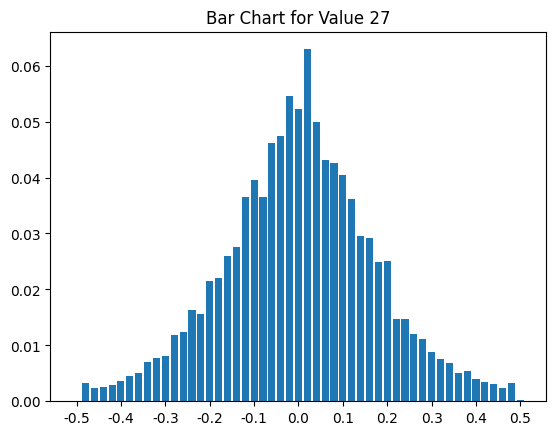

0.43025477189412226


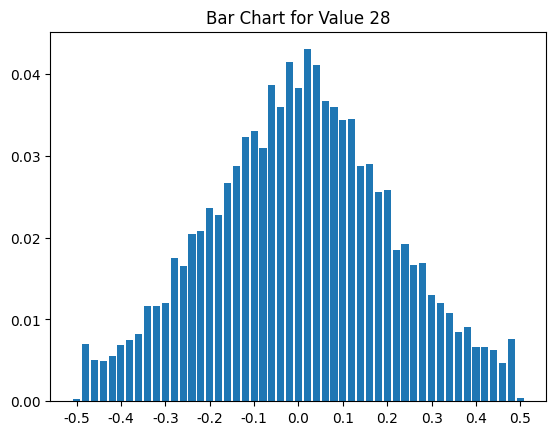

-1.1821526150713617


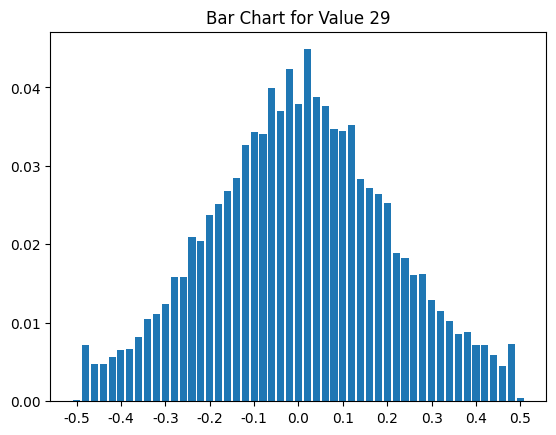

0.10737314613035337


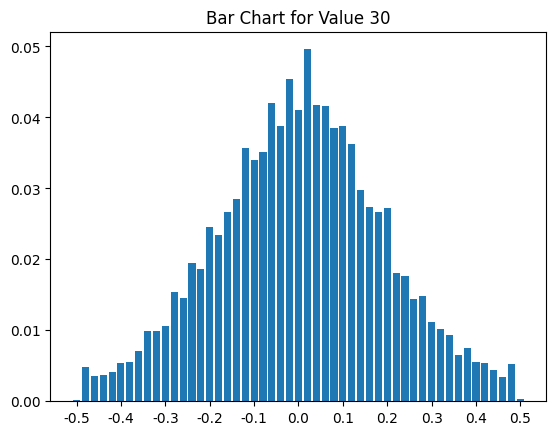

0.4295878579430021


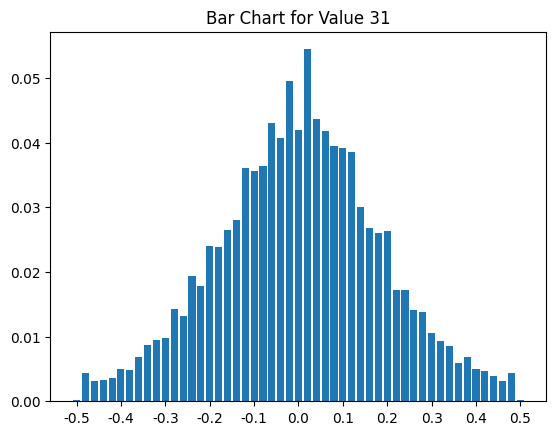

In [192]:

for i in range(5):
   num += 1
   dist = pred[num]

   val = target_list[0][num]

   values = np.linspace(-space, space, shape)

   #round the numbers to one decimal place and only include every other value
   values2 = [round(value, 2) for value in values[::5]]

   bin_centers = (values[:-1] + values[1:]) / 2
   dist2 = dist[:len(bin_centers)]

   # Calculate the mean of the distribution
   mean = np.sum(dist2 * bin_centers)

  # print(mean)
  # print(shape)
   print(val)

   # Create a new figure for each bar chart
   plt.figure()

   plt.bar(range(shape), dist)
   plt.xticks(range(len(dist))[::5], values2)
   plt.title(f'Bar Chart for Value {num}')
   plt.show()

